In [171]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [172]:
import pandas as pd
import numpy as np
import random
import os
import sys
import numpy as np
import tensorflow as tf
from transformers import logging

# setting up seed
seed = 123

os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

logging.set_verbosity_error()

BATCH_SIZE = 32
EVAL_BATCH_SIZE = 8
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 5
MAX_SEQ_LENGTH = 128 # before: 50

# Warmup is a period of time where hte learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 1000
SAVE_SUMMARY_STEPS = 500

# Loading the taxonomy
taxonomy = pd.read_csv('taxonomy.csv')

queries, labels = taxonomy['query'].to_numpy(), taxonomy['label'].to_numpy()

In [173]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize(sentence):
    tokens = tokenizer.encode_plus(sentence, max_length=MAX_SEQ_LENGTH,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_attention_mask=True,
                                   return_token_type_ids=False, return_tensors='tf')
    return tokens['input_ids'], tokens['attention_mask']

# initialize two arrays for input tensors
Xids = np.zeros((len(taxonomy), MAX_SEQ_LENGTH))
Xmask = np.zeros((len(taxonomy), MAX_SEQ_LENGTH))

for i, sentence in enumerate(taxonomy['query']):
    Xids[i, :], Xmask[i, :] = tokenize(sentence)

In [174]:
from sklearn.preprocessing import LabelEncoder

# Encoding the labels to binary values
bin_encoder=LabelEncoder()
taxonomy.label = bin_encoder.fit_transform(taxonomy.label)

In [175]:
label_values = taxonomy['label'].values  # take label column in the dataframe as array
labels = np.zeros((label_values.size, label_values.max()+1))  # initialize empty (all zero) label array
labels[np.arange(label_values.size), label_values] = 1  # add ones in indices where we have a value

In [176]:
import tensorflow as tf

# load arrays into tensorflow dataset
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

# create a mapping function that we use to restructure our dataset
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

# using map method to apply map_func to dataset
dataset = dataset.map(map_func)

# shuffle data and batch it
dataset = dataset.shuffle(500).batch(BATCH_SIZE)

In [177]:
# get the length of the batched dataset
DS_LEN = len([0 for batch in dataset])

train_size = int(0.7 * DS_LEN)
val_size = int(0.1 * DS_LEN)
test_size = int(0.2 * DS_LEN)

train = dataset.take(train_size)
test = dataset.skip(train_size)
val = test.skip(test_size)
test = test.take(test_size)

del dataset  # delete dataset to free up disk-space

In [178]:
import matplotlib.pyplot as plt

# Helper function for merging new history objects with older ones
def append_history(losses, val_losses, accuracy, val_accuracy, history):
    losses = losses + history.history["loss"]
    val_losses = val_losses + history.history["val_loss"]
    accuracy = accuracy + history.history["binary_accuracy"]
    val_accuracy = val_accuracy + history.history["val_binary_accuracy"]
    return losses, val_losses, accuracy, val_accuracy


# Plotter function
def plot_history(losses, val_losses, accuracies, val_accuracies):
    plt.plot(losses)
    plt.plot(val_losses)
    plt.legend(["train_loss", "val_loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.plot(accuracies)
    plt.plot(val_accuracies)
    plt.legend(["train_accuracy", "val_accuracy"])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()

In [179]:
from transformers import TFBertModel

def create_model():
    # initialize cased BERT model
    bert = TFBertModel.from_pretrained('bert-base-uncased')

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), name='input_ids', dtype='int32')
    mask = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), name='attention_mask', dtype='int32')

    # we consume the last_hidden_state tensor from bert (discarding pooled_outputs)
    embeddings = bert(input_ids, attention_mask=mask)[0]

    X = tf.keras.layers.LSTM(64)(embeddings)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Dense(64, activation='relu')(X)
    X = tf.keras.layers.Dropout(0.1)(X)
    y = tf.keras.layers.Dense(2, activation='softmax', name='outputs')(X)

    # define input and output layers of our model
    model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

    # freeze the BERT layer - otherwise we will be training 100M+ parameters...
    model.layers[2].trainable = False

    return model

In [180]:
def train_full_model(full_train_dataset, val_dataset, test_dataset):
    model = create_model()
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(
        optimizer="adam", 
        loss="binary_crossentropy",
        metrics=[            
            tf.keras.metrics.BinaryAccuracy(),
            tf.keras.metrics.FalseNegatives(),
            tf.keras.metrics.FalsePositives()
        ],
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(patience=4, verbose=1)
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                "FullModelCheckpoint.h5", verbose=1, save_best_only=True)
    history = model.fit(full_train_dataset, validation_data=val_dataset, epochs=5,
        callbacks=[early_stopping, model_checkpoint])
    
    # Plot history
    plot_history(
        history.history["loss"],
        history.history["val_loss"],
        history.history["binary_accuracy"],
        history.history["val_binary_accuracy"],
    )

    # Loading the best checkpoint
    model = tf.keras.models.load_model("FullModelCheckpoint.h5", custom_objects={"TFBertModel": TFBertModel})

    print("-" * 100)
    print(
        "Test set evaluation: ",
        model.evaluate(test_dataset, verbose=0, return_dict=True, batch_size=EVAL_BATCH_SIZE),
    )
    print("-" * 100)

    return model

Epoch 1/5
109/109 [==============================] - ETA: 0s - loss: 0.2462 - binary_accuracy: 0.9260 - false_negatives_23: 258.0000 - false_positives_23: 258.0000
Epoch 1: val_loss improved from inf to 0.20008, saving model to FullModelCheckpoint.h5
109/109 [==============================] - 92s 398ms/step - loss: 0.2462 - binary_accuracy: 0.9260 - false_negatives_23: 258.0000 - false_positives_23: 258.0000 - val_loss: 0.2001 - val_binary_accuracy: 0.9692 - val_false_negatives_23: 16.0000 - val_false_positives_23: 16.0000
Epoch 2/5
109/109 [==============================] - ETA: 0s - loss: 0.3166 - binary_accuracy: 0.8830 - false_negatives_23: 408.0000 - false_positives_23: 408.0000
Epoch 2: val_loss did not improve from 0.20008
109/109 [==============================] - 38s 350ms/step - loss: 0.3166 - binary_accuracy: 0.8830 - false_negatives_23: 408.0000 - false_positives_23: 408.0000 - val_loss: 0.3837 - val_binary_accuracy: 0.9731 - val_false_negatives_23: 14.0000 - val_false_posi

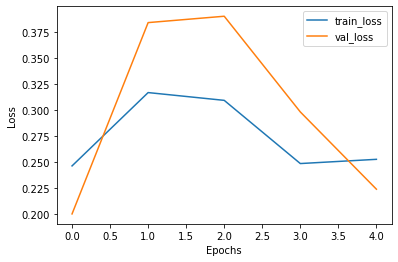

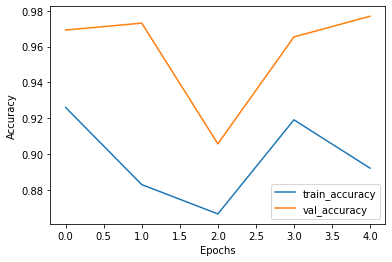

----------------------------------------------------------------------------------------------------
Test set evaluation:  {'loss': 0.15294621884822845, 'binary_accuracy': 0.9879032373428345, 'false_negatives_23': 12.0, 'false_positives_23': 12.0}
----------------------------------------------------------------------------------------------------


In [181]:
full_dataset_model = train_full_model(train, val, test)